In [ ]:
from __future__ import print_function, division
!pip install split-folders

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/project/Scenes training set",output = "Data",ratio = (0.8,0.2))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Copying files: 14034 files [04:21, 53.61 files/s] 


In [ ]:
!rmdir Data/train/.ipynb_checkpoints
!rmdir Data/val/.ipynb_checkpoints

rmdir: failed to remove 'Data/train/.ipynb_checkpoints': No such file or directory
rmdir: failed to remove 'Data/val/.ipynb_checkpoints': No such file or directory


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}
dir = "Data"
image_datasets = {x: datasets.ImageFolder(os.path.join(dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

Epoch 0/14
----------
train Loss: 0.6629 Acc: 0.7592
val Loss: 0.2509 Acc: 0.9146

Epoch 1/14
----------
train Loss: 0.4546 Acc: 0.8372
val Loss: 0.2215 Acc: 0.9302

Epoch 2/14
----------
train Loss: 0.3983 Acc: 0.8570
val Loss: 0.2455 Acc: 0.9181

Epoch 3/14
----------
train Loss: 0.3658 Acc: 0.8671
val Loss: 0.2450 Acc: 0.9132

Epoch 4/14
----------
train Loss: 0.3293 Acc: 0.8789
val Loss: 0.2257 Acc: 0.9270

Epoch 5/14
----------
train Loss: 0.3154 Acc: 0.8852
val Loss: 0.2562 Acc: 0.9146

Epoch 6/14
----------
train Loss: 0.3085 Acc: 0.8899
val Loss: 0.2230 Acc: 0.9270

Epoch 7/14
----------
train Loss: 0.2629 Acc: 0.9081
val Loss: 0.2031 Acc: 0.9331

Epoch 8/14
----------
train Loss: 0.2445 Acc: 0.9104
val Loss: 0.2035 Acc: 0.9313

Epoch 9/14
----------
train Loss: 0.2306 Acc: 0.9161
val Loss: 0.2091 Acc: 0.9310

Epoch 10/14
----------
train Loss: 0.2307 Acc: 0.9144
val Loss: 0.2097 Acc: 0.9260

Epoch 11/14
----------
train Loss: 0.2233 Acc: 0.9202
val Loss: 0.2119 Acc: 0.9310

Ep

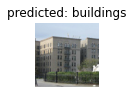

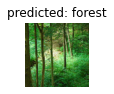

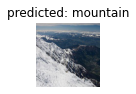

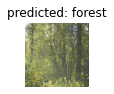

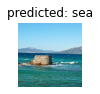

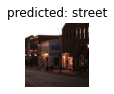

In [ ]:
model_ft = models.efficientnet_v2_s(pretrained = True)
num_ftrs = model_ft.classifier[1].in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[1] = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)
visualize_model(model_ft)

In [ ]:
torch.save(model_ft.state_dict(), "efficientnet_v2_s_model.pt")

In [ ]:
import pandas as pd
import numpy as np
from torch import Tensor

!rmdir /content/drive/MyDrive/test/.ipynb_checkpoints
dir = "/content/drive/MyDrive/test"
image_set = datasets.ImageFolder(os.path.join(dir),data_transforms["val"])
print(image_set)
loader = torch.utils.data.DataLoader(image_set, batch_size=8, shuffle=False)
correct = 0
samples = 0
values = np.array([])
names =np.array([])
for idx, (images, labels) in enumerate(loader):
    images = images.to(device=device)
    labels = labels.to(device=device)
    outputs = model_ft(images)
    _, preds = outputs.max(1)
    values =  np.r_[values,np.array(Tensor.cpu(preds))]
for i in range(3050):
    names = np.r_[names,np.array(loader.dataset.samples[i][0][48:])]

rmdir: failed to remove '/content/drive/MyDrive/test/.ipynb_checkpoints': No such file or directory
Dataset ImageFolder
    Number of datapoints: 3050
    Root location: /content/drive/MyDrive/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


In [ ]:
fil = np.c_[names[:,np.newaxis],values[:,np.newaxis]]
frame = pd.DataFrame(fil)
frame.style.hide_index()
frame.to_csv("preds.csv")